In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import wandb
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from src.utils import load_env_vars
from src.dataset import Cifar10DataManager
from src.model import build_model
import json
import glob

# Setup
env = load_env_vars()
PROJECT_NAME = env.get("WANDB_PROJECT", "cifar10_mlops_project")
ENTITY = env.get("WANDB_ENTITY", None)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load Data
run = wandb.init(project=PROJECT_NAME, job_type="evaluation")
artifact = run.use_artifact(f'{ENTITY}/{PROJECT_NAME}/cifar10_dataset:latest', type='dataset')
artifact_dir = artifact.download(root="../data")

dm = Cifar10DataManager(data_dir="../data")
# Get Test Loader
with open("../artifacts/best_config.json", "r") as f:
    config = json.load(f)

_, test_loader = dm.get_loaders(batch_size=100, architecture_option=config['architecture_option'])

# 2. Get Best Model from Sweep
try:
    with open("../artifacts/sweep_id.txt", "r") as f:
        sweep_id = f.read().strip()
    
    api = wandb.Api()
    sweep = api.sweep(f"{ENTITY}/{PROJECT_NAME}/{sweep_id}")
    best_run = sweep.best_run()
    
    print(f"Fetching model from best run: {best_run.id}")
    
    # Download Best Model Artifact
    # We look for the model artifact logged by that specific run
    artifacts = best_run.logged_artifacts()
    model_artifact = [a for a in artifacts if a.type == "model"][0] # Get first model artifact
    
    model_dir = model_artifact.download(root="../models")
    # Find .pth file
    model_path = glob.glob(os.path.join(model_dir, "*.pth"))[0]
    print(f"Model downloaded to: {model_path}")

    model = build_model(config['architecture_option']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 3. Evaluation (Confusion Matrix)
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Log Confusion Matrix to W&B
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
        y_true=all_labels, preds=all_preds, class_names=classes
    )})
    
    print("Evaluation Complete. Check W&B Dashboard.")
    
except Exception as e:
    print(f"Evaluation Failed: {e}")

run.finish()

# Model Evaluation

This notebook demonstrates how to fetch the best model from a W&B Sweep and evaluate it on the test set.


In [ ]:
import wandb
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Setup
PROJECT_NAME = "cifar10_mlops_project"

# --- AUTOMATION: READ SWEEP ID FROM FILE ---
try:
    with open("../artifacts/sweep_id.txt", "r") as f:
        SWEEP_ID = f.read().strip()
    print(f"Loaded Sweep ID: {SWEEP_ID}")
except FileNotFoundError:
    SWEEP_ID = "YOUR_SWEEP_ID_MANUALLY" # Fallback
    print("Sweep ID file not found. Please run notebook 02 first or set manually.")

ENTITY = None # Your available entity will be used automatically

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Initialize W&B API
api = wandb.Api()

# Get the sweep
if SWEEP_ID == "YOUR_SWEEP_ID_HERE":
    print("Please set the SWEEP_ID variable in the previous cell.")
else:
    sweep = api.sweep(f"{ENTITY}/{PROJECT_NAME}/{SWEEP_ID}")
    best_run = sweep.best_run()
    print(f"Best Run ID: {best_run.id}")
    print(f"Best Run Accuracy: {best_run.summary.get('val_acc')}")

    # Find the model artifact from this run
    # We named it f"model-best-{run.id}" in notebook 02
    artifact_name = f"model-best-{best_run.id}:v0" # version 0 is usually the first one
    # Note: If you logged multiple times it might be v1, v2... or use 'latest'

    # Alternatively, list artifacts produced by the run
    artifacts = best_run.logged_artifacts()
    model_artifact = None
    for a in artifacts:
        if a.type == "model":
            model_artifact = a
            break

    if model_artifact:
        print(f"Downloading artifact: {model_artifact.name}")
        artifact_dir = model_artifact.download()
        model_path = f"{artifact_dir}/model_best_{best_run.id}.pth"
        print(f"Model downloaded to: {model_path}")
    else:
        print("No model artifact found for the best run.")

wandb: Sorting runs by -summary_metrics.val_acc


Best Run ID: n08k4dxv
Best Run Accuracy: 81.42


wandb:   1 of 1 files downloaded.  


Model downloaded to: /content/artifacts/model-best-n08k4dxv:v0/model_best_n08k4dxv.pth


In [7]:
# Load Data (Test Set Only)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='../data/raw', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:19<00:00, 8.68MB/s]


In [8]:
# Re-define Model Architecture to load weights
def build_model():
    model = torchvision.models.resnet18(pretrained=False) # No need to download weights, we load ours
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    return model

if 'model_path' in locals():
    model = build_model()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully.")
else:
    print("Model path not defined. Did artifact download succeed?")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully.


              precision    recall  f1-score   support

       plane       0.70      0.81      0.75      1000
         car       0.85      0.77      0.81      1000
        bird       0.69      0.58      0.63      1000
         cat       0.57      0.51      0.54      1000
        deer       0.70      0.62      0.66      1000
         dog       0.66      0.63      0.64      1000
        frog       0.70      0.85      0.77      1000
       horse       0.72      0.81      0.76      1000
        ship       0.81      0.82      0.81      1000
       truck       0.81      0.78      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



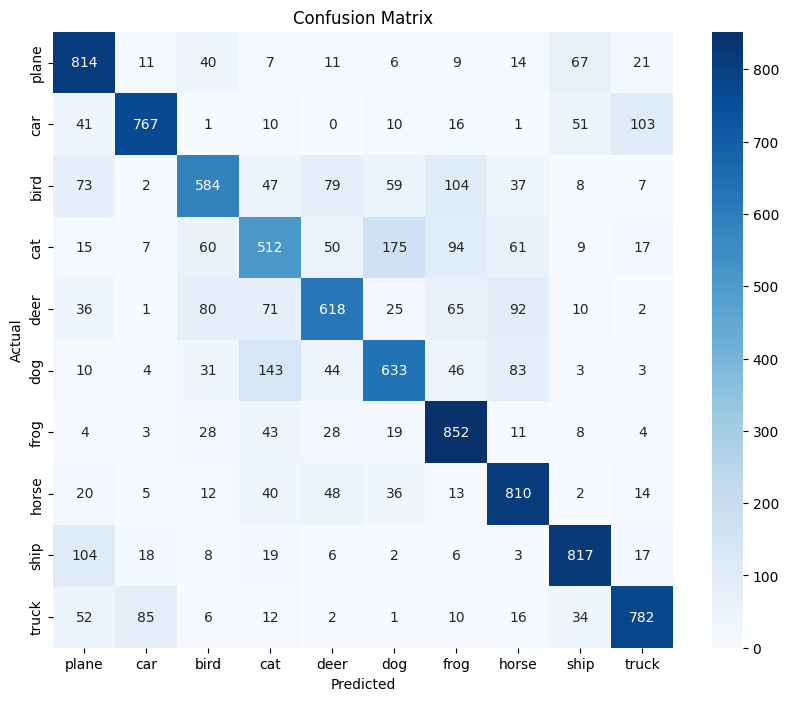

In [9]:
# Evaluate
if 'model' in locals():
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()